# Instruction-Tuning a Generative Pretrained Transformer

1. First, intall `transformers` library.

In [ ]:
%pip install transformers

-  Load the dataset.
-  Load GPT-2 Tokenizer and add the choosen special tokens (`'<|startoftext|>', '<|endoftext|>','<|pad|>'`)
-  Create demonstrations by prepending the special tokens.
-  Calculate the maximum lenght (in tokens) that the demonstrations have.

In [9]:
import pandas as pd
from datasets import load_dataset
from transformers import GPT2Tokenizer

model = "gpt2" # "gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl"
model_size = "124M" # "124M", "355M", "774M", and "1.5B"

dataset = load_dataset("nicholasKluge/fine-tuning-instruct-aira")


df = pd.DataFrame(dataset['aira_instruct_english'])

display(df)

tokenizer = GPT2Tokenizer.from_pretrained(model, 
    bos_token='<|startoftext|>', 
    eos_token='<|endoftext|>', 
    pad_token='<|pad|>')

# create column that concatenates the two sentences
df['demonstrations'] = tokenizer.bos_token + df['prompt'] + tokenizer.eos_token + df['completion'] + tokenizer.eos_token

# calculate the length of the text
df['length'] = df['demonstrations'].apply(lambda x: len(tokenizer.encode(x)))

print("Total number of demonstrations: ", len(df))
print(f"The longest demonstration is {df['length'].max()} tokens long.")

Found cached dataset parquet (C:/Users/CWLINK/.cache/huggingface/datasets/nicholasKluge___parquet/nicholasKluge--fine-tuning-instruct-aira-c7a6e731d782bc09/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/4 [00:00<?, ?it/s]

prompt  \
0      I was wondering if you could walk me through t...   
1                What type of wine goes best with steak.   
2            How do I know if this is a good investment.   
3          Please provide me with some financial advice.   
4      What kind of safety devices do I need to insta...   
...                                                  ...   
42869  How do computers communicate and network with ...   
42870  How are websites different from web applications?   
42871     What is open-source software and its benefits?   
42872  What is a cookie and how is it used in web bro...   
42873  What is cloud storage and its advantages for d...   

                                              completion  
0      Sure! The process for setting up a hydroponic ...  
1      The best type of wine to pair with steak depen...  
2      Answer: To determine if an investment is a goo...  
3      Some financial advice is to always pay yoursel...  
4      The type of safety devices you should install ...  
...                                                  ...  
42869  Computers communicate and network with each ot...  
42870  Websites and web applications are similar in t...  
42871  Open-source software is software that is made ...  
42872  A cookie is a small piece of data that a websi...  
42873  Cloud storage is a service that allows you to ...  

[42874 rows x 2 columns]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Total number of demonstrations:  42874
The longest demonstration is 299 tokens long.


2. Create the Dataset class.

In [11]:
import torch
from torch.utils.data import Dataset

max_length = 300

class DemoDataset(Dataset):

  def __init__(self, demonstrations, tokenizer, max_length=max_length):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for demo in demonstrations:

      encodings_dict = tokenizer(demo, 
          truncation=True, 
          max_length=max_length, 
          padding="max_length")
      
      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

3. Split the data into training ad validation splits.

In [12]:
from torch.utils.data import random_split

dataset = DemoDataset(df.demonstrations.to_list(), tokenizer, max_length=max_length)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('Number of training samples: {:,}'.format(train_size))
print('Number of validation samples: {:,}'.format(val_size))

Number of training samples: 38,586
Number of validation samples: 4,288


4. Create the `DataLoaders`.

In [7]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(
            train_dataset,  
            sampler=RandomSampler(train_dataset),
            batch_size=32
        )

# validation data loader doesn't need randomization
validation_dataloader=DataLoader(
            val_dataset, 
            sampler=SequentialSampler(val_dataset), 
            batch_size=32 
        )

5. load the base model.

In [8]:
from transformers import GPT2LMHeadModel, GPT2Config

configuration = GPT2Config.from_pretrained(model, output_hidden_states=False)

# instantiate the model with the configuration and resize token embeddings
model = GPT2LMHeadModel.from_pretrained(model, config=configuration)
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50259, bias=False)
)

- Freeze a portion of the model if you wish. `Aira` was trained to freeze 75% of the model (i.e., we trained only 25% of the final layers).

In [ ]:
UNFREEZE_LAST_N = 3 

print("Number of transformer blocks in the model: ", model.config.n_layer)
print("Number of transformer blocks to  un-freeze: ", UNFREEZE_LAST_N)

# - Freeze selective layers:
# - Freeze all layers except last n:
for parameter in model.parameters():
    parameter.requires_grad = False

for i, m in enumerate(model.transformer.h):        
    #Only un-freeze the last n transformer blocks
    if i+1 > model.config.n_layer - UNFREEZE_LAST_N:
        for parameter in m.parameters():
            parameter.requires_grad = True 

        for parameter in model.transformer.ln_f.parameters():        
            parameter.requires_grad = True

        for parameter in model.lm_head.parameters():        
            parameter.requires_grad = True

# Count the number of frozen and trainable layers
num_frozen_layers = sum(1 for parameter in model.parameters() if not parameter.requires_grad)
num_trainable_layers = sum(1 for parameter in model.parameters() if parameter.requires_grad)

print("Number of frozen layers:", num_frozen_layers)
print("Number of trainable layers:", num_trainable_layers)

6. Setting training parameters.

In [10]:
from transformers import get_linear_schedule_with_warmup

epochs = 5

warmup_steps = 1e2

sample_every = 100 # generate a sample every 100 batches

optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-4, eps = 1e-8)

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
    num_warmup_steps = warmup_steps, 
    num_training_steps = total_steps)

7. Training/Validation loop.

In [11]:
import tqdm

training_stats = []

for epoch_i in range(0, epochs):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(tqdm.tqdm(train_dataloader)):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids,
                        labels=b_labels, 
                        attention_mask = b_masks,
                        token_type_ids=None)

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Sample every 100 batches
        if step % sample_every == 0 and not step == 0:

            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}.')

            model.eval()

            inputs = tokenizer(tokenizer.bos_token + df.prompt.sample().iloc[0] + tokenizer.eos_token, return_tensors="pt").to(device)

            sample_outputs = model.generate(**inputs,
                                bos_token_id=tokenizer.bos_token_id,
                                pad_token_id=tokenizer.pad_token_id,
                                eos_token_id=tokenizer.eos_token_id,
                                do_sample=True,   
                                top_k=50, 
                                max_length = 200,
                                top_p=0.95, 
                                num_return_sequences=1)
                                
            for i, sample_output in enumerate(sample_outputs):
                  print(f'Example output: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)       

    print(f'Average Training Loss: {avg_train_loss}.')

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids,  
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    print(f'Validation loss: {avg_val_loss}.')

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
        }
    )

print("Training complete!")

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats.to_parquet("./training_stats.parquet", compression="gzip")

Beginning epoch 1 of 5


 35%|███▌      | 100/283 [01:00<01:43,  1.77it/s]

Batch 100 of 283. Loss:0.92487633228302.
Example output: How does deep learning impact privacy and safeguarding of data?Deep learning enables a model to perform tasks in a manner that is both deterministic and intelligent: it employs an adversarial approach in such a way that is often transparent, but is not biased in its results. It has advantages over natural language processing.


 71%|███████   | 200/283 [01:58<00:47,  1.76it/s]

Batch 200 of 283. Loss:0.7599731683731079.
Example output: What are the main applications of machine learning?Machine learning encompasses tasks such as identifying and extracting patterns in data, analyzing data, and analyzing patterns in the data. It also includes several computational tasks such as segmentation, clustering, and machine learning algorithms that aim to gather information across several dimensions.


100%|██████████| 283/283 [02:46<00:00,  1.70it/s]


Average Training Loss: 1.7797733711690868.
Validation loss: 0.6214480362832546.
Beginning epoch 2 of 5


 35%|███▌      | 100/283 [00:56<01:43,  1.77it/s]

Batch 100 of 283. Loss:0.6944515109062195.
Example output: What are some of the major debates in the field of epistemology?Epistemology is an intriguing field of study that centers around the study of the epistemology of texts. Scholars and philosophers from various religions, from Plato to Xenophon have explored this field in tandem. There have also been several controversies surrounding the extent to which certain individuals can make substantial contributions to the study of epistemology, including those of Socrates and Marcus Aurelius. Epistemology offers a fascinating exploration of one of the primary strands of social science, namely the role of the mind in epistemology.


 71%|███████   | 200/283 [01:55<00:47,  1.76it/s]

Batch 200 of 283. Loss:0.6129528284072876.
Example output: Can you explain the origin of Occam's razor?The ancient Greek philosopher Zeno of Citium, known as Stoics, was the first to argue for the existence of objective reality. In his treatise on the subject, he presented the threefold nature of things, namely, the objective nature, relative knowledge, and personal perception.


100%|██████████| 283/283 [02:42<00:00,  1.74it/s]


Average Training Loss: 0.598113334221048.
Validation loss: 0.5255831023678184.
Beginning epoch 3 of 5


 35%|███▌      | 100/283 [00:56<01:43,  1.77it/s]

Batch 100 of 283. Loss:0.5187301635742188.
Example output: How can we ensure that AI does not compromise the privacy of children and adolescents?AI technologies should be developed to ensure that they comply with human rights, which include Child and Adolescent Rights. The primary objective of this principle is to establish ethical standards and standards for AI development and use.


 71%|███████   | 200/283 [01:53<00:47,  1.77it/s]

Batch 200 of 283. Loss:0.49698150157928467.
Example output: How far are we from achieving general artificial intelligence?The realm of General Intelligence encompasses the capability of AGI to undertake any task that can be undertaken by any intelligent entity, including, but not limited to, Artificial General Intelligence (AGI).


100%|██████████| 283/283 [02:41<00:00,  1.76it/s]


Average Training Loss: 0.5052632845332682.
Validation loss: 0.48149530217051506.
Beginning epoch 4 of 5


 35%|███▌      | 100/283 [00:56<01:43,  1.77it/s]

Batch 100 of 283. Loss:0.4454309046268463.
Example output: How does Goodhart's law work?In the realm of machine learning, Goodhart's Law stands as one of three noteworthy law-based optimization techniques, along with Alignment Daemons, which have been instrumental in achieving significant benefits for machine learning.


 71%|███████   | 200/283 [01:53<00:47,  1.77it/s]

Batch 200 of 283. Loss:0.4759449064731598.
Example output: In what ways does the creative process get impacted by deep learning?The realm of deep learning is dedicated to the exploration of novel means of creating engaging and immersive artworks. The ability to imbibe these outputs imbued with profound emotional and ethical significance enables individuals to imbibe these exceptional creations with greater comprehension and comprehension.


100%|██████████| 283/283 [02:41<00:00,  1.75it/s]


Average Training Loss: 0.45279810411770016.
Validation loss: 0.46003800816833973.
Beginning epoch 5 of 5


 35%|███▌      | 100/283 [00:56<01:43,  1.76it/s]

Batch 100 of 283. Loss:0.4711158275604248.
Example output: How does a feedforward neural network work?An FNN is a type of neural network that lacks cyclic or recursive connections, unlike the recurrent neural networks of RNNs. The FNN's main purpose is to form a graph over a time sequence, then display dynamic behavior using the feedforward pass through it. This allows the network to exhibit dynamic behavior that is proportional to the number of folds in the graph. The Feedforward Neural Network (FNN) is an example of a FNN, famously known as Inner-Neural Zoo.


 71%|███████   | 200/283 [01:54<00:47,  1.77it/s]

Batch 200 of 283. Loss:0.4309981167316437.
Example output: How does Aumann's agreement theorem relate to Nash Equilibrium?According to Aumann's Agreement Theorem, two rational agents who share common principles are obligated to act in accordance with one another's beliefs, and this means they must inevitably come to a mutual agreement.


100%|██████████| 283/283 [02:42<00:00,  1.75it/s]


Average Training Loss: 0.42189987072253815.
Validation loss: 0.4528817282989621.


8. Plotting Learning Curves.

|   epoch |   Training Loss |   Valid. Loss |
|--------:|----------------:|--------------:|
|       1 |        0.852566 |      0.574185 |
|       2 |        0.549692 |      0.544331 |
|       3 |        0.481956 |      0.53601  |

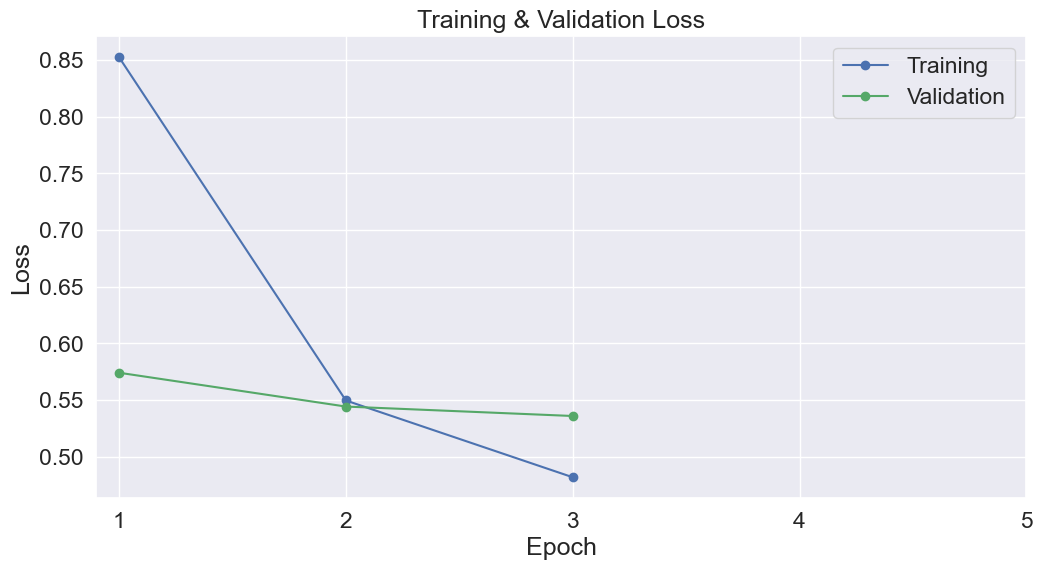

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_stats = pd.read_parquet("./training_stats.parquet")

display(Markdown(df_stats.to_markdown()))
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])

plt.show()

9. Saving te model.

In [22]:
import os

output_dir = 'your_directory_here'

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

10. Test the model.

In [14]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from IPython.display import HTML
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = GPT2Tokenizer.from_pretrained('nicholasKluge/Aira-Instruct-124M')
aira = GPT2LMHeadModel.from_pretrained('nicholasKluge/Aira-Instruct-124M') 

aira.to(device)
aira.eval()

question = input("Enter your question: ")

inputs = tokenizer(tokenizer.bos_token + question + tokenizer.eos_token, return_tensors="pt").to(device)

responses = aira.generate(**inputs,
    bos_token_id=tokenizer.bos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    do_sample=True,   
    top_k=50, 
    max_length=200,
    top_p=0.95,
    temperature=0.7, 
    num_return_sequences=3)

print(f"Question: 👤 {question}\n")

for i, response in enumerate(responses):

    # print only the response and remove the question
    display(HTML(f'<b>Response {i+1}: 🤖 {tokenizer.decode(response, skip_special_tokens=True).replace(question, "")}</b>'))

Question: 👤 What time is now?



Done 🤗